In [25]:
#import statements
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import sklearn
import matplotlib.pyplot as plt

# Loading raw data

This data has been gathered from https://pubs.acs.org/doi/suppl/10.1021/ci9901338/suppl_file/ci9901338_s.pdf, with the SMILEs already attached.

I have already edited some of the files to make it cleaner to load. This involved the following:
    1. Replacing any tabs with spaces, replacing double spaces with a single space.
    2. Combining train.smi and test1.smi into a single dataset.
    3. Keeping only the CAS_Number, Name, Log S and Smiles columns.
    4. Saving the data as: alldata.csv and test2.csv
    
If you wish, you may do this for yourself, by downloading the raw files from here: http://cheminformatics.org/datasets/huuskonen/index.html

Otherwise, you are welcome to use the .csv files generated for you.


In [26]:
data = pd.read_csv("../data/alldata.csv", index_col=0)
data.head()

,CAS_Number,Name,Log S,Smiles
0,109-66-0,n-pentane,-3.18,CCCCC
1,287-92-3,cyclopentane,-2.64,C1CCCC1
2,110-54-3,n-hexane,-3.84,CCCCCC
3,107-83-5,2-methylpentane,-3.74,CCCC(C)C
4,75-83-2,"2,2-dimethylbutane",-3.55,CCC(C)(C)C


In [27]:
#count the number of data entries
print(len(data))

1291


In the paper, they have 1297 compounds, whilst we have 1291 here. 

Why is this?

In [ ]:
#think, then double click on the markdown cell below.


<font color="white">
<i> It is likely that we have less due to the SMILEs strings - if they were not able to be parsed by the data owner, they were excluded from the dataset.</i></font>

Let's do a check on a molecule to see if we have accurate data.

We can use pandas directly to do this:

    data[data["Column"] == "String"]] 
    
Replace 'Column' and 'String' with a molecule of your choice and see if you can find it in the raw data [table](https://pubs.acs.org/doi/suppl/10.1021/ci9901338/suppl_file/ci9901338_s.pdf).

In [28]:
data[data["Name"]=="acetamide"]

,CAS_Number,Name,Log S,Smiles
602,60-35-5,acetamide,1.58,CC(=O)N


We will be working with Smiles strings as input to our modelling work, so we need to make sure these are unique.
 
You can use value_counts() on a column to find the number of matches to each unique value.
e.g.

    data["Name"].value_counts()
    
The output is generated so that values with the highest counts are listed first.
    
Do this for the Smiles column.

In [ ]:
#work here


We can specify to only look at those that have a count > 1.
Don't forget to save your value_counts() as a variable first.

    counts[counts > 1]


In [29]:
#work here
counts = data["Smiles"].value_counts()
counts[counts>1]

ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl            2
CC(=O)OCC(=O)C3(O)CCC4C2CCC1=CC(=O)CCC1(C)C2C(=O)CC34C    2
C1C(C)C(C)CCC1                                            2
O=C(OC(CC(N(C1C2)C)C2)C1)C(c(cccc3)c3)CO                  2
CN(C)C(=O)Nc1cccc(OC(=O)NC(C)(C)C)c1                      2
Name: Smiles, dtype: int64

Let's look at the top example.

In [30]:
data[data["Smiles"]=="ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl"] # Replace None with the relevant smiles

,CAS_Number,Name,Log S,Smiles
146,72-20-8,endrin,-6.18,ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl
109,60-57-1,dieldrin,-6.29,ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl


Both endrin and dieldrin have the same chemical formula: C12H8Cl6O

We can draw the molecules to see how RDKit visualises the SMILES representation - We'll look more at this in another notebook.

To do this we need to do a few steps first:
    1. Chem.MolFromSmiles(smiles)
    2. Draw.MolToImage(mol)

Take a look at the rdkit documentation for more information on these functions http://www.rdkit.org/Python_Docs/rdkit.Chem.rdmolfiles-module.html
    
Step 1 takes the smiles string as an argument, and converts it into an RDKit molecule type, so that we can perform further processing using rdkit features.
Step 2 takes the mol as an argument, and constructs an image.

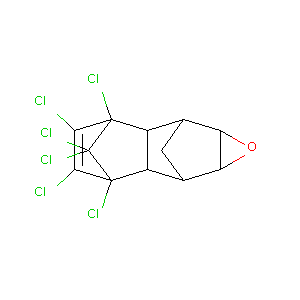

In [31]:
smiles = "ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl"
mol = Chem.MolFromSmiles(smiles)

Draw.MolToImage(mol)

An issue with canonical smiles strings is that tautomers of the same molecule will typically be represented by the same SMILES
string. It is therefore often better to use Inchis which can be non-standardised, and are able to represent tautomers.

However, as we have no other tautomer information, we will stick with SMILEs.

This means that if this is used as input, even though for different tautomers, the descriptors generated will be the same.
We will have repeated data, which can cause a problem if one version of the repeat is in the test, and another in the training! 

If endrin, with a Log S of -6.18 is present in the training set, and dieldrin is present in the test set with a Log S of -6.29, we can always expect dieldrin to have **at least** an error of -0.11 (not considering training error).

What should you do? 
1. Keep all?
2. Remove all?
3. Keep one?
    - Which?

My preference here would be to try to find a way to represent these molecules so that they can become different entities, and then to make sure they end up in the same training/test set. 
However, due to limitations of the data, we'll just remove them.

How would you save the indexes of this 'counts' dataframe as list?
Remember to only save those that have a value_counts() > 1!

In [32]:
multiple_mols = counts[counts > 1].index.tolist()
print(multiple_mols)

['ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl', 'CC(=O)OCC(=O)C3(O)CCC4C2CCC1=CC(=O)CCC1(C)C2C(=O)CC34C', 'C1C(C)C(C)CCC1', 'O=C(OC(CC(N(C1C2)C)C2)C1)C(c(cccc3)c3)CO', 'CN(C)C(=O)Nc1cccc(OC(=O)NC(C)(C)C)c1']


We can do a quick one liner for excluding all of these from the dataframe.

You've already seen:

       data[data["Name"] == "X"]
       
We can check for presence in a list according to:

        data[data["Name"].isin(X)]
            
Where X is your list variable.

How would you change this line, so it becomes 

    '"Name" is not in list X'?
    
Hint:<br><font size=5>~</font>

In [33]:
unique_data = data[~data["Smiles"].isin(multiple_mols)] #Replace None with the code.

#We then need to reset the index, so we can avoid copy errors
unique_data.reset_index(drop=True,inplace=True)
unique_data.head()

,CAS_Number,Name,Log S,Smiles
0,109-66-0,n-pentane,-3.18,CCCCC
1,287-92-3,cyclopentane,-2.64,C1CCCC1
2,110-54-3,n-hexane,-3.84,CCCCCC
3,107-83-5,2-methylpentane,-3.74,CCCC(C)C
4,75-83-2,"2,2-dimethylbutane",-3.55,CCC(C)(C)C


We finally need to check that all our data has a Log S value, as this is what we are trying to predict.

In [34]:
assert(np.all(unique_data["Log S"].isnull())==False)

In the 'data sets' paragraph:
    
<blockquote>A set of 1297 organic compounds was extracted from these databases and was divided into a training set of 884 compounds and a randomly chosen test set of 413 compounds.</blockquote>

You can use sklearn's train_test_split function for this! [Wiki here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) 

Have a look at the wiki, and try and split the unique_data into training, and 413 'test' molecules. Don't forget, due to SMILES, we have slightly fewer!

In [35]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(unique_data, test_size=413) #replace None with the correct code

#save these as the correct csv files.
train.to_csv("../train.csv")
test.to_csv("../test1.csv")

print(len(train))
print(len(test))

868
413


We can then use a handy pandas function to get some statistics.

    data.describe()

    data["Name"].describe()

In [36]:
#work here 
train.describe()
test.describe()

,Log S
count,413.000000
mean,-2.649153
std,2.025222
min,-8.940000
25%,-3.750000
50%,-2.470000
75%,-1.210000
max,1.580000


How does our means, minimums, maximums and standard deviations compare to those in the paper?

<blockquote>The Log S values of the training set ranged from -11.62 to +1.58 with a mean of -2.70 and standard deviation of 2.01. For the testing set, the smallest log S value was -10.41 and the largest +1.13. The mean and standard deviation were -2.77 and 2.07, respectively. </blockquote>

We could compare our train and test data in a box plot.

In [37]:
# we need to combine into a list so we can plot them
data = [train["Log S"],test["Log S"]]

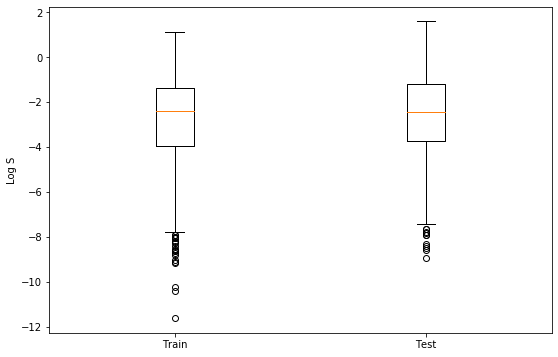

In [38]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_ylabel("Log S")
ax.set_xticklabels(["Train","Test"])
plt.show()

Does the training data look to be representative of the test data?


## What about the second test set?

Do the plot again, but also with the Log S data from test

In [40]:
test2 = pd.read_csv("../data/test2.csv", index_col=0)
test2.head()

,CAS_Num,Name,Log S,Smiles
0,37680-73-2,"2,2´,4,5,5´-PCB",-7.89,Clc1ccc(Cl)c(c1)c2cc(Cl)c(Cl)cc2Cl
1,94-09-7,benzocaine,-2.32,O=C(OCC)c(ccc(N)c1)c1
2,50-78-2,acetylsalicylic_acid,-1.72,O=C(Oc(c(ccc1)C(=O)O)c1)C
3,58-55-9,theophylline,-1.39,CN1C(=O)N(C)c2ncnc2C1(=O)
4,60-80-0,antipyrine,-0.56,c1ccccc1N2C(=O)C=C(C)N2C


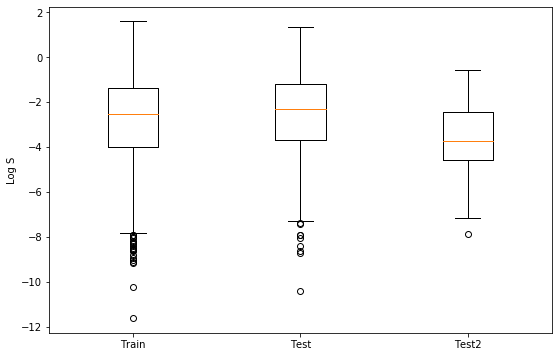

In [24]:
# work here

# we need to combine into a list so we can plot them
data = [train["Log S"],test["Log S"],test2["Log S"]]

fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_ylabel("Log S")
ax.set_xticklabels(["Train","Test","Test2"])
plt.show()